In [255]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [312]:
#VARIABLE DESCRIPTIONS

#Item_Identifier Unique product ID
#Item_Weight Weight of product
#Item_Fat_Content Whether the product is low fat or not
#Item_Visibility The % of total display area of all products in a store allocated to the particular product
#Item_Type The category to which the product belongs
#Item_MRP Maximum Retail Price (list price) of the product
#Outlet_Identifier Unique store ID
#Outlet_Establishment_Year The year in which store was established
#Outlet_Size The size of the store in terms of ground area covered
#Outlet_Location_Type The type of city in which the store is located
#Outlet_Type Whether the outlet is just a grocery store or some sort of supermarket
#Item_Outlet_Sales Sales of the product in the particulat store. This is the outcome variable to be predicted.

#Read the train and test files
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train['istest'] = 0
test['istest'] = 1
df = pd.concat([train, test], ignore_index=True)
print train.shape, test.shape, df.shape

(8523, 13) (5681, 12) (14204, 13)


In [313]:
df.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,istest
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,0
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,0
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,0
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.000000,19.20,1998,OUT010,Tier 3,NaN,Grocery Store,0
4,Low Fat,NCD19,53.8614,994.7052,Household,0.000000,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,0


In [314]:
df.apply(lambda x: sum(x.isnull()))

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
istest                          0
dtype: int64

Item Outlet Sales has the same number of missing values as the observations in the test set, so we don't need to impute that. We need to impute Item_Weight and Outlet_Size.

In [315]:
df.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year,istest
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681,0.399958
std,62.086938,1706.499616,0.051459,4.652502,8.371664,0.489907
min,31.290000,33.290000,0.000000,4.555000,1985.000000,0.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000,0.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000,0.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000,1.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000,1.000000


Need to compute the number of years the store has been active and selling products. Item Visibility of zero doesn't
make sense since the item was purchased from the store. 

In [316]:
#Unique categories for categorical variables 
df.apply(lambda x: len(x.unique()))

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
istest                           2
dtype: int64

There are 1559 products and 10 stores and there are 16 categories of items being sold. Now we will observe the frequency of the categorical variables. 

In [317]:
cat_var = [x for x in df.dtypes.index if df.dtypes[x]=='object']
#exclude ids and istest
cat_var = [x for x in cat_var if x not in ['Item_Identifier', 'Outlet_Identifier', 'istest']]
#frequency of categories
for col in cat_var:
    print '\n Frequency of Categories for %s' %col
    print df[col].value_counts()    


 Frequency of Categories for Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

 Frequency of Categories for Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

 Frequency of Categories for Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

 Frequency of Categories for Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

 Frequency of Categories for 

For 'Item_Fat_Content', all the low fat and regular categories need to be combined to 2 categories. For Item Type, the low frequency categories may be combined. We will impute item weight using average item weight for the particular item.

In [318]:
#Average weight per item:
item_avg_wt = df.pivot_table(values='Item_Weight',index='Item_Identifier')

#Identify observations with missing item weight
miss_item_wt = df['Item_Weight'].isnull()
df.loc[miss_item_wt, 'Item_Weight'] = df.loc[miss_item_wt, 'Item_Identifier'].apply(lambda x: item_avg_wt[x])
print 'Missing Item Weight Variable: %d' % sum(df.Item_Weight.isnull())

Missing Item Weight Variable: 0


In [319]:
#Impute Outlet Size
from scipy.stats import mode
outlet_size_m = df.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: mode(x).mode[0]))
miss_out_size = df.Outlet_Size.isnull()
df.loc[miss_out_size, 'Outlet_Size'] = df.loc[miss_out_size, 'Outlet_Type'].apply(lambda x: outlet_size_m[x])
print "Missing Outlet Size Variable: %d" % sum(df.Outlet_Size.isnull())

Missing Outlet Size Variable: 0


In [320]:
#Visibility of Product
item_vis_avg = df.pivot_table(values='Item_Visibility', index='Item_Identifier')
miss_item_vis = (df.Item_Visibility == 0)
df.loc[miss_item_vis, 'Item_Visibility'] = df.loc[miss_item_vis, 'Item_Identifier'].apply(lambda x:item_vis_avg[x])
print "Number of 0 values: %d" %sum(df.Item_Visibility==0)

Number of 0 values: 0


In [321]:
#Item Visibility as a ratio of avg. item visibility by item identifier
df['Item_Visibility_AvgRatio'] = df.apply(lambda x: x['Item_Visibility']/item_vis_avg[x['Item_Identifier']], axis=1)
print df.Item_Visibility_AvgRatio.describe()

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_AvgRatio, dtype: float64


In [322]:
#Combine Item Types
#Extract the first 2 characters of ID:
df['Item_Type_Combined'] = df.Item_Identifier.apply(lambda x:x[0:2])
df['Item_Type_Combined'] = df.Item_Type_Combined.map({'FD':'Food', 'NC':'Non-Consumable', 'DR': 'Drinks'})
df.Item_Type_Combined.value_counts()
list(df)

['Item_Fat_Content',
 'Item_Identifier',
 'Item_MRP',
 'Item_Outlet_Sales',
 'Item_Type',
 'Item_Visibility',
 'Item_Weight',
 'Outlet_Establishment_Year',
 'Outlet_Identifier',
 'Outlet_Location_Type',
 'Outlet_Size',
 'Outlet_Type',
 'istest',
 'Item_Visibility_AvgRatio',
 'Item_Type_Combined']

In [323]:
#Number of years the stores have been opened
df.loc[:,'store_yrs'] = 2013 - df.Outlet_Establishment_Year
list(df)

['Item_Fat_Content',
 'Item_Identifier',
 'Item_MRP',
 'Item_Outlet_Sales',
 'Item_Type',
 'Item_Visibility',
 'Item_Weight',
 'Outlet_Establishment_Year',
 'Outlet_Identifier',
 'Outlet_Location_Type',
 'Outlet_Size',
 'Outlet_Type',
 'istest',
 'Item_Visibility_AvgRatio',
 'Item_Type_Combined',
 'store_yrs']

In [324]:
#Combined item_fat_content categories
df.Item_Fat_Content = df.Item_Fat_Content.replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'})
print df.Item_Fat_Content.value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [325]:
#Item fat content of non-consumables
df.loc[df.Item_Type_Combined == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'
df.Item_Fat_Content.value_counts()
list(df)

['Item_Fat_Content',
 'Item_Identifier',
 'Item_MRP',
 'Item_Outlet_Sales',
 'Item_Type',
 'Item_Visibility',
 'Item_Weight',
 'Outlet_Establishment_Year',
 'Outlet_Identifier',
 'Outlet_Location_Type',
 'Outlet_Size',
 'Outlet_Type',
 'istest',
 'Item_Visibility_AvgRatio',
 'Item_Type_Combined',
 'store_yrs']

In [326]:
#Prepare data for modeling
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['store'] = le.fit_transform(df.Outlet_Identifier)
var = ['Item_Fat_Content', 'Outlet_Location_Type', 'Outlet_Size', 'Item_Type_Combined', 'Outlet_Type', 'store']
for i in var:
    df[i] = le.fit_transform(df[i])
#One Hot Coding:
df = pd.get_dummies(df, columns=['Item_Fat_Content', 'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type', 'Item_Type_Combined', 'store'])

In [327]:
#Create analytical dataset
df.drop(['Item_Type', 'Outlet_Establishment_Year'], axis=1, inplace=True)
df.istest.value_counts()
#Split train and test
train = df.loc[df.istest==0]
test = df.loc[df.istest==1]
#keep columns needed for the model
train.drop(['istest'], axis=1, inplace=True)
test.drop(['istest', 'Item_Outlet_Sales'],axis=1, inplace=True)
#Save to csv files
train.to_csv('train_anal.csv', index=False)
test.to_csv('test_anal.csv', index=False)

C:\Users\nvarana\AppData\Local\Continuum\Anaconda2_64\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\nvarana\AppData\Local\Continuum\Anaconda2_64\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [328]:
#Model store/item sales 
#Naive model - use overall avg. sales as prediction
avg_sales = train.Item_Outlet_Sales.mean()
model_1 = test[['Item_Identifier', 'Outlet_Identifier']]
model_1.loc[:,'Item_Outlet_Sales'] = avg_sales
#export to csv file
model_1.to_csv('model_1.csv', index=False)

In [329]:
#Function to define a model, cross-validate and generate a submission
outcome = 'Item_Outlet_Sales'
idcol = ['Item_Identifier', 'Outlet_Identifier']
from sklearn import model_selection as ms

def model_fit(algo, train, test, predictors, outcome, idcol, filename):
    #fit the algorithm on the data
    algo.fit(train[predictors], train[outcome])
    
    #predict training set:
    train_pred = algo.predict(train[predictors])
    
    #perform cross-validation:
    seed=7
    kfold = ms.KFold(n_splits=10, random_state=seed)
    cv_score = ms.cross_val_score(algo, train[predictors], train[outcome], cv=kfold, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #print model report
    print "\n Model Results"
    print "RMSE : %.4g" % np.sqrt(mt.mean_squared_error(train[outcome].values, train_pred))
    
    print "CV Score : Mean= %.4g | Std.= %.4g | Min.= %.4g | Max.= %.4g" % (np.mean(cv_score), np.std(cv_score),
                                                                            np.min(cv_score), np.max(cv_score))
    
    #predict on testing data
    test.loc[:,outcome] = algo.predict(test[predictors])
    
    #export to csv file
    idcol.append(outcome)
    model_2 = pd.DataFrame({x: test[x] for x in idcol})
    model_2.to_csv(filename, index=False)    


 Model Results
RMSE : 1127
CV Score : Mean= 1130 | Std.= 16.34 | Min.= 1109 | Max.= 1163


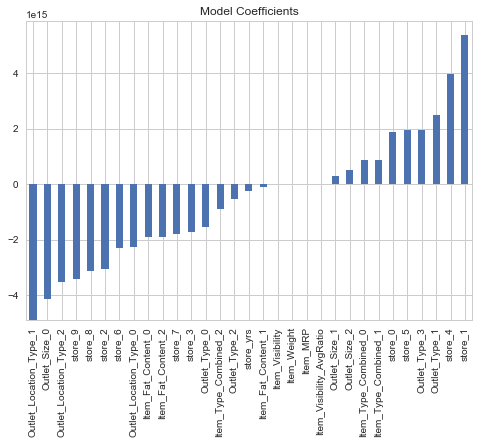

In [336]:
#Linear Regression Model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [outcome]+idcol]

algo_1 = LinearRegression(normalize=True)
model_fit(algo_1, train, test, predictors, outcome, idcol, 'algo_1.csv')
coef_1 = pd.Series(algo_1.coef_, predictors).sort_values()
coef_1.plot(kind='bar', title='Model Coefficients')


 Model Results
RMSE : 1129
CV Score : Mean= 1131 | Std.= 17.85 | Min.= 1110 | Max.= 1167


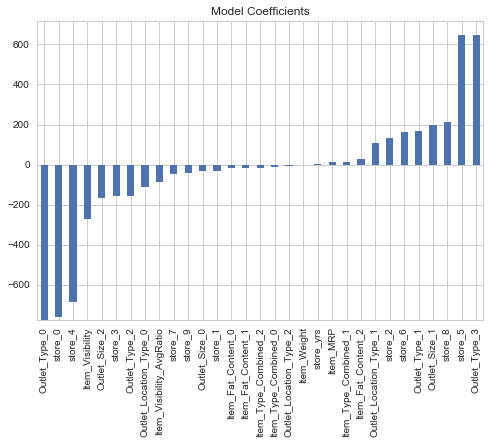

In [337]:
#Since some of the coefficients are very large in magnitude, it signifies overfitting. So we will use ridge regression 
#to avoid overfitting
algo_2 = Ridge(alpha=0.05, normalize=True)
model_fit(algo_2, train, test, predictors, outcome, idcol, 'algo_2.csv')
coef_2 = pd.Series(algo_2.coef_, predictors).sort_values()
coef_2.plot(kind='bar', title='Model Coefficients')


 Model Results
RMSE : 1058
CV Score : Mean= 1094 | Std.= 22.58 | Min.= 1063 | Max.= 1129


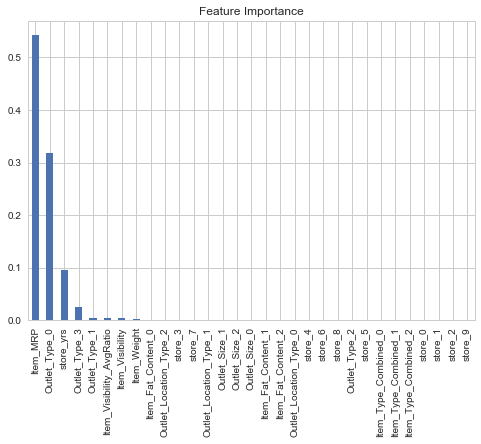

In [338]:
#Since Ridge Regression doesn't seem to improve the cross validation score relative to the Linear Regression, let us 
#fit a decision tree model to examine if we can get a lower RMSE.
from sklearn.tree import DecisionTreeRegressor as dt
algo_3 = dt(max_depth=15, min_samples_leaf=100)
model_fit(algo_3, train, test, predictors, outcome, idcol, 'algo_3.csv')
coef_3 = pd.Series(algo_3.feature_importances_ , predictors).sort_values(ascending=False)
coef_3.plot(kind='bar', title='Feature Importance')

In [339]:
#Since the RMSE is 1058 and the mean CV error is 1091, this model is slightly overfitting. The feature importance plot
#shows the top 4 variables are important, so let us fit the tree with the top 4 variables 
predictors = ['Item_MRP', 'Outlet_Type_0', 'store_yrs', 'Outlet_Type_3']
algo_4 = dt(max_depth=8, min_samples_leaf=150)
model_fit(algo_4, train, test, predictors, outcome, idcol, 'algo_4.csv')


 Model Results
RMSE : 1071
CV Score : Mean= 1094 | Std.= 21.02 | Min.= 1064 | Max.= 1132



 Model Results
RMSE : 1068
CV Score : Mean= 1085 | Std.= 20.43 | Min.= 1049 | Max.= 1113


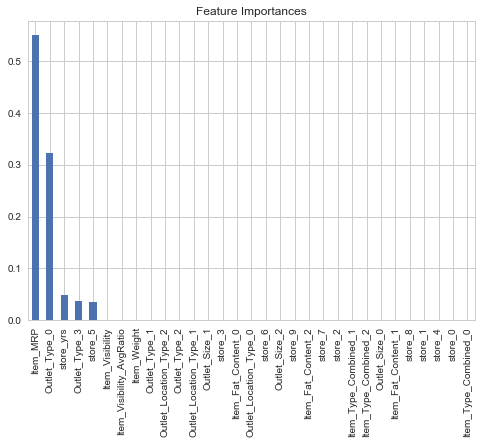

In [340]:
#Since the RMSE and the cross validation error didn't change much, let us try an ensemble model such as RandomForest
from sklearn.ensemble import RandomForestRegressor as rf
predictors = [x for x in train.columns if x not in [outcome]+idcol]

algo_5 = rf(n_estimators=400, max_depth=6, min_samples_leaf=100, n_jobs=4)
model_fit(algo_5, train, test, predictors, outcome, idcol, 'algo_5.csv')
coef_5 = pd.Series(algo_5.feature_importances_, predictors).sort_values(ascending=False)
coef_5.plot(kind='bar', title='Feature Importances')


 Model Results
RMSE : 1070
CV Score : Mean= 1084 | Std.= 20.02 | Min.= 1051 | Max.= 1114


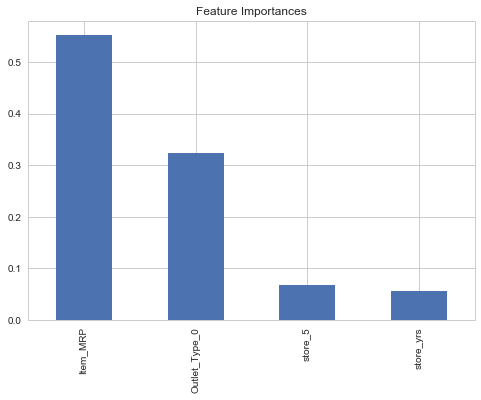

In [342]:
predictors = ['Item_MRP', 'Outlet_Type_0', 'store_yrs', 'store_5']

algo_5 = rf(n_estimators=400, max_depth=6, min_samples_leaf=100, n_jobs=4)
model_fit(algo_5, train, test, predictors, outcome, idcol, 'algo_5.csv')
coef_5 = pd.Series(algo_5.feature_importances_, predictors).sort_values(ascending=False)
coef_5.plot(kind='bar', title='Feature Importances')

We will use the RandomForest model with most important featuers to predict item and store sales in the test data since it achieves the trade-off of low RMSE and stable cross-validation error. 